In [18]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import *
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing

import matplotlib.pyplot as plt

pd.options.mode.use_inf_as_na = True

In [2]:
data = pd.read_csv('Data/merged_data.csv')

In [3]:
def compute_features(df_raw):
    df = df_raw.copy()

    df['adv_sale']=df['xad']/df['sale']
    df['aftret_eq']=df['ni']/df['ceq']
    df['aftret_equity']=df['ni']/df['teq']
    df['aftret_invcapx']=df['ni']/df['icapt']
    df['at_turn']=df['sale']/df['at']
    df['bm']=df['teq']/df['mkvalt']
    df['cash_debt']=(df['ivncf']+df['oancf']+df['fincf'])/(df['dltt']+df['dlc'])
    df['cash_lt']=(df['ch'])/df['lt']
    df['cash_ratio']=df['che']/df['lct']
    df['cfm']=df['oancf']/df['sale']
    df['curr_debt']=df['lct']/df['lt']
    df['curr_ratio']=df['act']/df['lct']
    df['de_ratio']=(df['dltt']+df['dlc'])/df['teq']
    df['debt_assets']=(df['dltt']+df['dlc'])/df['at']
    df['debt_capital']=(df['dltt']+df['dlc'])/(df['dltt']+df['dlc']+df['teq'])
    df['debt_ebitda']=(df['dltt']+df['dlc'])/df['ebitda']
    df['debt_invcap']=df['dltt']/df['icapt']
    df['dltt_be']=df['dltt']/df['teq']
    df['equity_invcap']=df['ceq']/df['icapt']
    df['evm']=(df['mkvalt']+df['dltt']+df['dlc']-df['ceq'])/df['ebitda']
    df['gpm']=df['gp']/df['sale']
    df['GProf']=df['gp']/df['at']
    # df['int_totdebt']=(df['intpn']-df['niint'])/(df['dltt']+df['dlc'])
    # df['intcov']=(df['ni']+df['intpn']-df['niint'])/df['intpn']
    df['intcov_ratio']=df['ebit']/df['intpn']
    df['inv_turn']=df['cogs']/df['invt']
    df['invt_act']=df['invt']/df['act']
    df['lt_debt']=df['dltt']/df['lt']
    df['lt_ppent']=df['lt']/(df['at']-df['intan'])
    df['npm']=df['ni']/df['sale']
    df['ocf_lct']=df['oancf']/df['lct']
    df['opmad']=df['ebit']/df['sale']
    df['opmbd']=df['ebitda']/df['sale']
    df['pcf']=df['prcc_f']/(df['ivncf']+df['oancf']+df['fincf'])
    df['pretret_noa']=df['pi']/(df['at']-df['ch']-df['lt']+df['dltt']+df['dlc'])
    df['profit_lct']=df['ebitda']/df['lct']
    df['ps']=df['prcc_f']/df['sale']
    df['ptb']=df['prcc_f']/df['teq']
    df['ptpm']=df['pi']/df['sale']
    df['quick_ratio']=(df['che']+df['rect'])/df['lct']
    df['RD_SALE']=df['xrd']/df['sale']
    df['rect_act']=df['rect']/df['act']
    df['rect_turn']=df['sale']/df['rect']
    df['roa']=df['ni']/df['at']
    df['roe']=df['ni']/df['teq']
    df['sale_equity']=df['sale']/df['teq']
    df['sale_invcap']=df['sale']/df['icapt']
    df['short_debt']=df['dlc']/(df['dltt']+df['dlc'])
    # df['staff_sale']=df['xstfws']/df['sale']
    df['totdebt_invcap']=(df['dltt']+df['dlc'])/df['icapt']
    
    return(df)

data_w = compute_features(data)

In [4]:
def select_features(df):
    
    # Selecting the feature matrix
    X = df[df.columns.difference(['Y','CUSIP'])].to_numpy()
    y = df['Y'].to_numpy()
    
    # Standardising the input features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    X_scaled = np.insert(X_scaled, 0, df['CUSIP'].to_numpy(), axis = 1)
    
    # Returning X and y values
    return(X_scaled,y)

In [5]:
def fill_na_df(df):
    df = df.sort_values(by='YEAR')
    df = df.fillna(method="ffill").fillna(method="bfill")
    df['Y'] = df['Y'].shift(1)
    df = df.dropna()
    return df

def get_raw_data(data_w):
    if 'BANKRUPTCY_FLAG' in list(data_w.columns):
        data_w = data_w.rename(columns = {'BANKRUPTCY_FLAG':'Y'}) 

        columns = ['YEAR','adv_sale','aftret_eq','aftret_equity','aftret_invcapx','at_turn','bm','cash_debt','cash_lt','cash_ratio','cfm','curr_debt','curr_ratio','de_ratio','debt_assets','debt_capital','debt_ebitda','debt_invcap','dltt_be','equity_invcap','evm','gpm','GProf','intcov_ratio','inv_turn','invt_act','lt_debt','lt_ppent','npm','ocf_lct','opmad','opmbd','pcf','pretret_noa','profit_lct','ps','ptb','ptpm','quick_ratio','RD_SALE','rect_act','rect_turn','roa','roe','sale_equity','sale_invcap','short_debt','totdebt_invcap']
        columns.append('Y')
        data_w[columns] = data_w[columns].apply(pd.to_numeric)
        columns.append('CUSIP')
        d = data_w[columns].groupby(['CUSIP']).apply(fill_na_df).dropna().reset_index(drop=True)
        
        le = preprocessing.LabelEncoder()
        le.fit(d['CUSIP'].unique())
        d['CUSIP'] = le.transform(d['CUSIP'])
        return d

d = get_raw_data(data_w)
print(d.head())

   YEAR  adv_sale  aftret_eq  aftret_equity  aftret_invcapx   at_turn  \
0  1992  0.005247   0.432293       0.234489        0.204967  2.357593   
1  1993  0.005247   0.419685       0.234489        0.250682  1.884898   
2  1994  0.005247   0.445075       0.234489        0.230721  2.442786   
3  1995  0.005247   0.152739       0.234489        0.085351  2.090712   
4  1996  0.005247   0.132673       0.234489        0.084295  1.766848   

         bm     cash_debt   cash_lt  cash_ratio  ...  rect_act  rect_turn  \
0  0.259451 -2.547981e-08  0.005408    0.008449  ...  0.444935   8.967304   
1  0.259451  3.962685e-09  0.006372    0.008493  ...  0.511537   5.594528   
2  0.259451 -7.510359e-09  0.001232    0.002487  ...  0.500400   6.685325   
3  0.259451  5.473919e-08  0.035519    0.083177  ...  0.465554   6.839935   
4  0.259451 -5.790228e-08  0.006925    0.012599  ...  0.550791   4.641776   

        roa       roe  sale_equity  sale_invcap  short_debt  totdebt_invcap  \
0  0.101433  0.2344

# Function to Evaluate Model

In [38]:
def get_reg_scores(clf,X_test, y_test):
    y_pred = clf.predict(X_test)
    # print(f"Classification score:{classification_report(y_test, y_pred)}")
    print(f"Accuracy score:{accuracy_score(y_test, y_pred)}")
    print(f"ROC AUC score:{roc_auc_score(y_test, y_pred)}")
    print(f"F1 score:{f1_score(y_test, y_pred)}")
    print(f"Precision Score:{precision_score(y_test, y_pred)}")
    print(f"Recall Score:{recall_score(y_test, y_pred)}")
    print(f"Confusion Martix:\n{confusion_matrix(y_test, y_pred)}")
    
    prob_predicted = pd.DataFrame(clf.predict_proba(X_test))
    prob_predicted.columns = ['prob_no_bankruptcy','prob_bankruptcy']
    # print(f"Predicted Probability:\n{prob_predicted}")
    
    # prob_predicted['decile'] = pd.qcut(prob_predicted['prob_bankruptcy'], q=10, labels = range(1,11))
    print(f"Predicted Probability Deciles:\n{prob_predicted}")
    
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    plt.plot(fpr,tpr,label="Area under Curve: "+ str(roc_auc))
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.legend(loc=4)
    plt.xlabel('False Positive (%)')
    plt.ylabel('True Positive (%)')
    plt.title('Forcasting 1991-2019 using 1964-1990 data')
    plt.show()

    print('#'*20)
    print()

# Logistic Regression

In [6]:
def train_logistic_reg(X,y, class_weight='balanced', scoring='recall'):
    logistic_regression_hparams = {
        'penalty' : ['l1','l2'],
        'C' : [0.01,0.033,0.1, 0.2, 0.5, 1]
    }

    cv_param = None
    clf_logistic = GridSearchCV(LogisticRegression(random_state=42,
                                                   solver='liblinear',
                                                   max_iter=100,
                                                   # class_weight={0:1,1:50}
                                                   class_weight=class_weight
                                                  ), 
                                param_grid=logistic_regression_hparams,
                                # scoring='f1',
                                scoring=scoring,
                                cv=cv_param,
                                n_jobs=-1
                               )
    clf_logistic.fit(X, y)
    print(f"Best Params:{clf_logistic.best_params_}")
    return clf_logistic   

## Train and test for in sample data

Best Params:{'C': 0.01, 'penalty': 'l1'}
Accuracy score:0.6636292500694146
ROC AUC score:0.6722299291855531
F1 score:0.004779686333084392
Precision Score:0.002398261260586075
Recall Score:0.6808510638297872
Confusion Martix:
[[26259 13311]
 [   15    32]]
Predicted Probability Deciles:
       prob_no_bankruptcy  prob_bankruptcy decile
0                0.648643         0.351357      4
1                0.716263         0.283737      3
2                0.623899         0.376101      5
3                0.567869         0.432131      6
4                0.606842         0.393158      5
...                   ...              ...    ...
39612            0.123543         0.876457     10
39613            0.163529         0.836471     10
39614            0.226012         0.773988     10
39615            0.237673         0.762327     10
39616            0.644947         0.355053      4

[39617 rows x 3 columns]


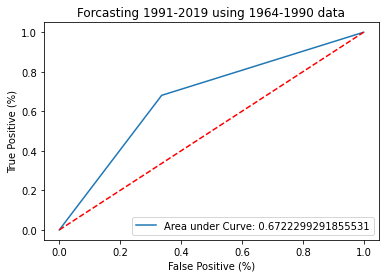

####################



In [172]:
d1 = d.drop(['YEAR'], axis=1)
X, y = select_features(d1)
# No train test split is needed for in sample data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = train_logistic_reg(X,y,scoring='f1')
get_reg_scores(clf, X, y)

## Train and test for out of sample period

Best Params:{'C': 0.033, 'penalty': 'l1'}
Classification score:              precision    recall  f1-score   support

         0.0       1.00      0.88      0.93     32215
         1.0       0.00      0.25      0.00        36

    accuracy                           0.88     32251
   macro avg       0.50      0.56      0.47     32251
weighted avg       1.00      0.88      0.93     32251

Accuracy score:0.8765309602803014
ROC AUC score:0.5636155517616017
F1 score:0.0045000000000000005
Precision Score:0.002270433905146317
Recall Score:0.25
Confusion Martix:
[[28260  3955]
 [   27     9]]
Predicted Probability Deciles:
       prob_no_bankruptcy  prob_bankruptcy decile
0                0.963867         0.036133      4
1                0.986629         0.013371      2
2                0.922918         0.077082      5
3                0.872894         0.127106      6
4                0.930800         0.069200      5
...                   ...              ...    ...
32246            0.024673  

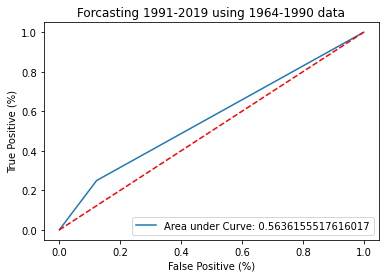

####################



In [167]:
# In sample training data
d_train = d[d['YEAR'] <= 1990]
# Out of sample test data
d_test = d[d['YEAR'] > 1990]

# Train the model
d1 = d_train.drop(['YEAR'], axis=1)
X, y = select_features(d1)
class_weight = {0:1, 1:int(np.count_nonzero(y == 0) / np.count_nonzero(y == 1))}
clf = train_logistic_reg(X,y, class_weight)

# Use test data to test the classifier
d1 = d_test.drop(['YEAR'], axis=1)
X, y = select_features(d1)
get_reg_scores(clf, X, y)

## Lasso Regression

C:\ProgramData\Anaconda3\envs\MFI_Assignment_11\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0078952359634048, tolerance: 0.0006991683638832311
  positive,
C:\ProgramData\Anaconda3\envs\MFI_Assignment_11\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011782626765540982, tolerance: 0.0006991683638832311
  positive,
C:\ProgramData\Anaconda3\envs\MFI_Assignment_11\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013222525086191261, tolerance: 0.0006991683638832311
  positive,
C:\ProgramData\Anaconda3\envs\MFI_Assignment_11\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644:

Non zero coefficients:['lt_ppent', 'ocf_lct']
Best Params:{'C': 0.01, 'penalty': 'l2'}
Classification score:              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     32215
         1.0       0.00      0.03      0.00        36

    accuracy                           0.97     32251
   macro avg       0.50      0.50      0.49     32251
weighted avg       1.00      0.97      0.99     32251

Accuracy score:0.9739853027813091
ROC AUC score:0.5014102298791108
F1 score:0.0023781212841854937
Precision Score:0.0012422360248447205
Recall Score:0.027777777777777776
Confusion Martix:
[[31411   804]
 [   35     1]]
Predicted Probability Deciles:
       prob_no_bankruptcy  prob_bankruptcy decile
0                0.646877         0.353123      9
1                0.649416         0.350584      8
2                0.663063         0.336937      6
3                0.681115         0.318885      3
4                0.669604         0.330396      5
...            

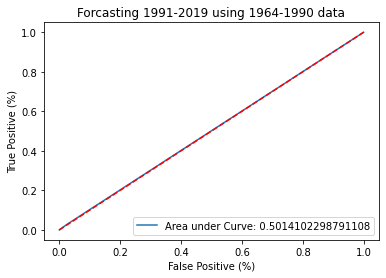

####################



In [80]:
# Run Lasso for feature selection
d_train = d[d['YEAR'] <= 1990]
# Out of sample test data
d_test = d[d['YEAR'] > 1990]

# Train the model
d1 = d_train.drop(['YEAR','CUSIP'], axis=1)
X, y = select_features(d1)

reg = LassoCV(cv=5, random_state=42, max_iter=10000)
reg.fit(X, y)
coef = pd.Series(reg.coef_, index = d1[d1.columns.difference(['Y'])].columns)

cols = list(coef[coef != 0].index)

print(f"Non zero coefficients:{cols}")
cols.append('Y')

X, y = select_features(d1[cols])
clf = train_logistic_reg(X,y)

d1 = d_test.drop(['YEAR','CUSIP'], axis=1)
X, y = select_features(d1[cols])
get_reg_scores(clf, X, y)


In [174]:
le = preprocessing.LabelEncoder()
le.fit(['0123','2345'])
le.transform(['0123','2345','0123','0123'])
le.inverse_transform([0])

array(['0123'], dtype='<U4')

## Ridge Regression

In [83]:
def train_ridge_reg(X,y, class_weight='balanced'):
    hparams = {
        'alpha' : [0.1, 1, 10]
    }

    cv_param = None
    clf = GridSearchCV(Ridge(solver='auto'), 
                                param_grid=hparams,
                                # scoring='f1',
                                scoring='recall',
                                cv=cv_param,
                                n_jobs=-1
                               )
    clf.fit(X, y)
    print(f"Best Params:{clf.best_params_}")
    return clf

In [98]:
# Try to use SMOTE
# Run Lasso for feature selection
d_train = d[d['YEAR'] <= 1990]
# Out of sample test data
d_test = d[d['YEAR'] > 1990]

# Train the model
d1 = d_train.drop(['YEAR','CUSIP'], axis=1)
X, y = select_features(d1)
clf = train_ridge_reg(X,y)

d1 = d_test.drop(['YEAR','CUSIP'], axis=1)
X, y = select_features(d1)

# Ridge regression is not a classifer so cannot get classification report on this model(does not make sense either)
get_reg_scores(clf, X, y)


Best Params:{'alpha': 0.1}


C:\ProgramData\Anaconda3\envs\MFI_Assignment_11\lib\site-packages\sklearn\model_selection\_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  category=UserWarning,


ValueError: Classification metrics can't handle a mix of binary and continuous targets

## KNN

In [41]:
def train_knn(X, y, cv_param=5):
    hparams = {
        'n_neighbors': np.arange(1,150,2)
    }

    cv_param = None
    clf = GridSearchCV(KNeighborsClassifier(),
                       param_grid=hparams,
                       scoring='accuracy',
                      cv=cv_param,
                       n_jobs=-1
                      )
    clf.fit(X, y)
    print(f"Best Params:{clf.best_params_}")
    return clf

Best Params:{'n_neighbors': 5}
Accuracy score:0.9988913857677902
ROC AUC score:0.5
F1 score:0.0
Precision Score:0.0
Recall Score:0.0
Confusion Martix:
[[33338     0]
 [   37     0]]


C:\Users\rohan\Anaconda3\envs\quant_general\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Predicted Probability Deciles:
       prob_no_bankruptcy  prob_bankruptcy
0                     1.0              0.0
1                     1.0              0.0
2                     1.0              0.0
3                     1.0              0.0
4                     1.0              0.0
...                   ...              ...
33370                 1.0              0.0
33371                 1.0              0.0
33372                 1.0              0.0
33373                 1.0              0.0
33374                 1.0              0.0

[33375 rows x 2 columns]


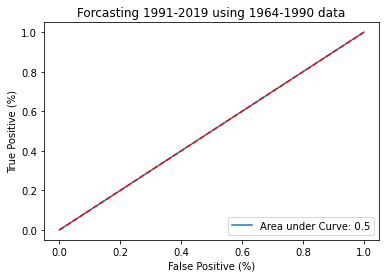

####################



In [43]:
# In sample training data
d_train = d[d['YEAR'] <= 1990]
# Out of sample test data
d_test = d[d['YEAR'] > 1990]

# Train the model
d1 = d_train.drop(['YEAR'], axis=1)
X, y = select_features(d1)
X_smote, y_smote = oversample.fit_resample(X, y)

# clf = train_knn(X_smote, y_smote)
clf = train_knn(X, y)

# Use test data to test the classifier
d1 = d_test.drop(['YEAR'], axis=1)
X, y = select_features(d1)
get_reg_scores(clf, X, y)

## Random Forest

## Survival Random Forest

## Gradient Boosted trees (XGBOOST)

## Gradient Boosted trees (LIGHTGBM)